# Histogram Area Detectors


The code does the following:
  1. Given an experiment string containing a run, open the run in index mode to obtain the number of events, and create detector objects.
  2. Apply the standard calibration for each detector when opening the images (using det.calib())
  3. Plot image histograms for area detectors, clipping to p < 0.02 to select the majority of the density.
  4. Save each 

Given a raw image raw, the image corrections are, in order:
  1. Remove pedistals
  2. Apply common-mode correction (correlation between adjacent pixels)
  3. Apply gain mask (differences in ADU/photon for different pixels)
  4. ROI/unbonded pixels masking (remove unwanted pixels that don't contain photon data)
 
 
**WARNING**: If the files for a particular run aren't available on disk (because they've been moved to tape) the DataSource will fail silently! Make sure the files are available on disk in the Data Manager.
 

## Imports and definitions

In [1]:
import psana
import numpy as np
from pathlib2 import Path
from x340helpers import *
from skimage import exposure
from itertools import islice

%matplotlib notebook
from matplotlib.pyplot import *

In [2]:
rcParams['figure.figsize'] = 10, 8

In [3]:
def load_image_data(detector, events, threshold=None, cmpars=None, mbits=MbitMask.PIXEL_STATUS, quantiles=[0.1, 99.9]):
    # select detector
    d = detectors[detector]
    nevents = len(events)
    # get frame shape
    s = tuple(d.shape()) # cspad detectors return a np.array for shape instead of tuple

    # allocate space for the calibrated frames
    data = np.empty((nevents,) + s, dtype=np.float32)

    for i,evt in enumerate(events):
        tmp = d.calib(evt, mbits=mbits, cmpars=cmpars)
        data[i] = np.nan if tmp is None else tmp

    data = np.nan_to_num(data) # remove empty frames
    
    vmin, vmax = np.percentile(data, quantiles)
    data_orig = custom_threshold(data, lower=vmin, upper=vmax)
    
    # if no threshold set
    data2 = data_orig if threshold is None else custom_threshold(data, lower=threshold, lvalue=0.)
    return data_orig, data2

## Configuration

In [4]:
expstr = "exp=xppls7917:run=116"
nevents = 100

## Open in index mode

In [5]:
# create figure directory if it doesn't exist
figdir = Path('figures')
figdir.mkdir(exist_ok=True)

ds = psana.DataSource(expstr + ':idx')
run = next(ds.runs())
event_times = run.times()
count = len(event_times)
detnames = [d[0] if d[1] == '' else d[1] for d in psana.DetNames()]

print('Opened {}, run with {} events'.format(expstr, count))
print('Found {} detectors:'.format(len(detnames)))
for name in detnames:
    print('\t' + name)

# construct detectors
detectors = {name: psana.Detector(name) for name in (detnames[:10] +detnames[13:15])}

# run number for accessing calib-store using detector interface
calib_store_nr = run.run()

# select the first N events
events = [run.event(et) for et in event_times[:nevents]]

Opened exp=xppls7917:run=116, run with 111561 events
Found 15 detectors:
	evr1
	usbencoder
	cspad
	evr0
	epix_1
	EBeam
	PhaseCavity
	FEEGasDetEnergy
	XppMon_Pim0
	XppMon_Pim1
	XppEnds_Ipm0
	XPP-SB2-BMMON
	XPP-SB3-BMMON
	opal_1
	ControlData


In [6]:
d = detectors['ControlData']()
for c in d.pvControls():
    print(c.name())

ccmE_vernier


In [12]:
detectors['cspad'].env

psana.Env()

## CSPAD threshold

<IPython.core.display.Javascript object>


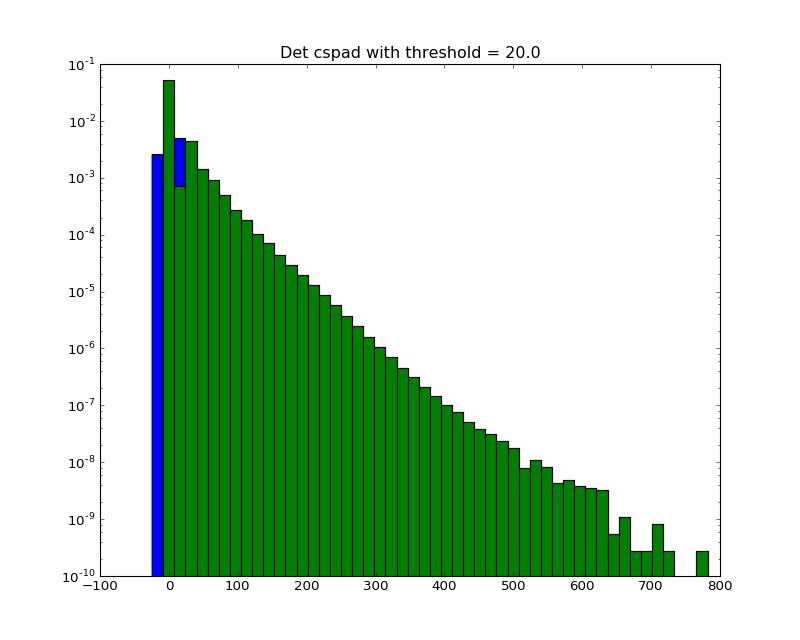

In [7]:
det = 'cspad'
threshold=20.
bitmask = MbitMask.PIXEL_MASK | MbitMask.PIXEL_STATUS | MbitMask.UNBONDED
data_orig, data_clipped = load_image_data(det, events, threshold=threshold, quantiles=[0.001, 100], mbits=bitmask)

figure()
counts, bins, _ = hist(data_orig.ravel(), 50, normed=True)
hist(data_clipped.ravel(), bins=bins, normed=True);
yscale('log')
title('Det {det} with threshold = {threshold}'.format(det=det, threshold=threshold))
savefig('figures/hist-run{run}-{det}.png'.format(run=run.run(), det=det), bbox_inches='tight')

## Epix threshold

<IPython.core.display.Javascript object>


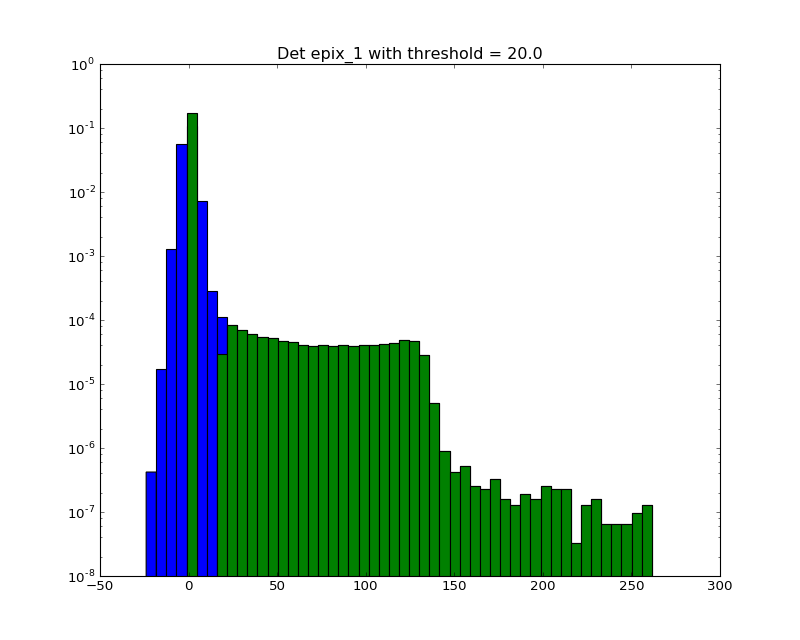

<IPython.core.display.Javascript object>


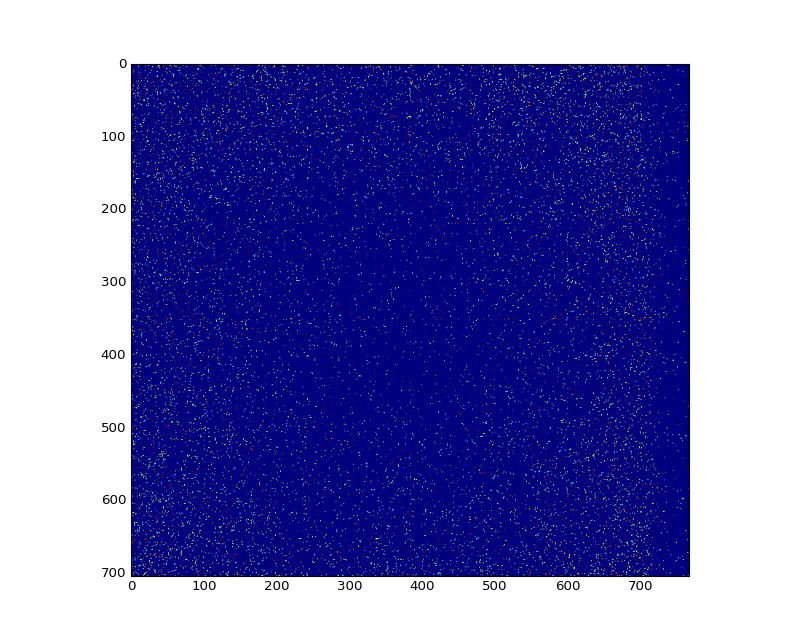

2.32208e+06


In [96]:
det = 'epix_1'
threshold=20.
bitmask = MbitMask.PIXEL_MASK | MbitMask.PIXEL_STATUS

data_orig, data_clipped = load_image_data(det, events[0:10], threshold=threshold, quantiles=[0.0, 100], mbits=bitmask)

figure()
counts, bins, _ = hist(data_orig.ravel(), 50, normed=True)
hist(data_clipped.ravel(), bins=bins, normed=True);
yscale('log')
title('Det {det} with threshold = {threshold}'.format(det=det, threshold=threshold))
savefig('figures/hist-run{run}-{det}.png'.format(run=run.run(), det=det), bbox_inches='tight')

#figure()
#imshow(np.sum(data_orig[0:10],axis=0))

avg = data_clipped.sum(axis=0)
vmin, vmax = np.percentile(avg, [1, 99])
figure()
imshow(avg, vmin=vmin, vmax=vmax)
print(np.sum(data_orig[0:10]))

<IPython.core.display.Javascript object>


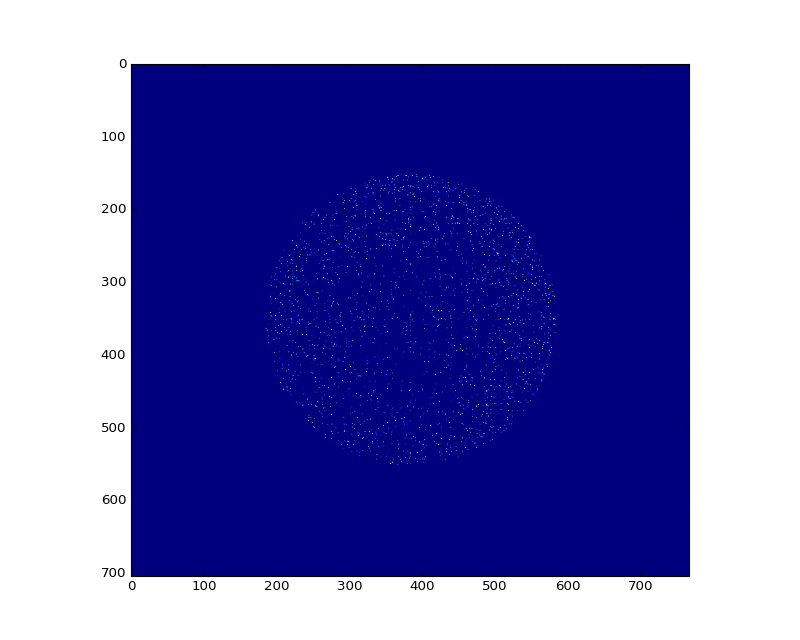

In [111]:
import skimage.draw as draw
#center = ()

shape = detectors['epix_1'].shape()
center = [shape[0]/2, shape[1]/2]
radius = 200
cindx = draw.circle(center[0], center[1], radius, shape=shape)

mask = np.zeros(shape=shape, dtype=avg.dtype)
mask[cindx] = 1.
figure()
imshow(mask*avg)

## Construct radial mask

We need to average more full-frames to see anything, so ... like do it

In [199]:
from pyimgalgos.HPolar import cart2polar, HPolar

# select the first N events
events = [run.event(et) for et in islice(event_times, None, 500)]

In [8]:
d = detectors['cspad']
bitmask = MbitMask.PIXEL_MASK | MbitMask.PIXEL_STATUS | MbitMask.UNBONDED8 | MbitMask.CSPAD_CENTRAL | MbitMask.EDGE_PIXELS
orig, _ = load_image_data('cspad', events, mbits=bitmask)
Z = orig.mean(axis=0)

<IPython.core.display.Javascript object>


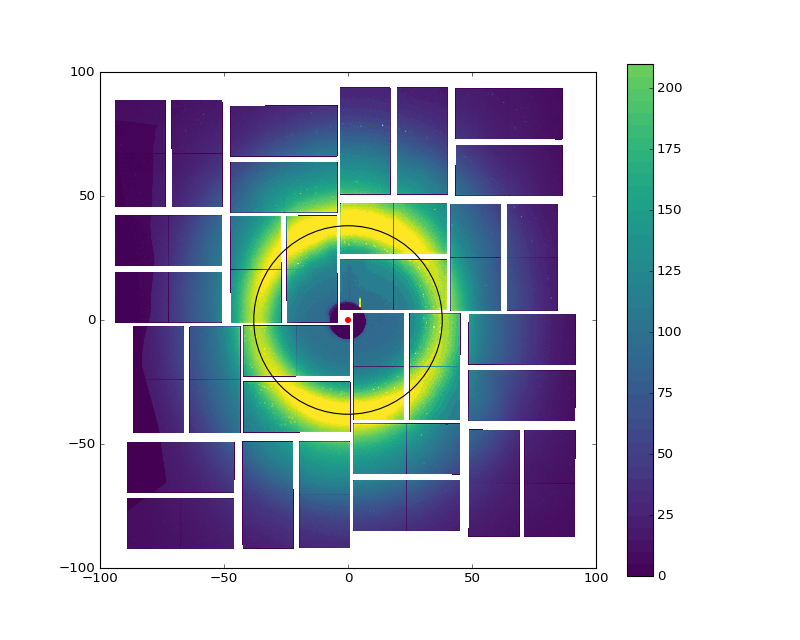

In [251]:
figure()
X, Y = d.coords_xy(events[0])
# mask lower corners of X and Y
center = 89.2469, 92.4957

X2 = X/1000 - center[0]
Y2 = Y/1000 - center[1]

R, Theta = cart2polar(X2.reshape(-1), Y2.reshape(-1))

vmin, vmax = np.percentile(Z[0], [1, 99])
for i in range(len(X2)):
    tricontourf(X2[i].ravel(), Y2[i].ravel(), Z[i].ravel(), 50, vmin=vmin, vmax=vmax, cmap='viridis')

ax = gca()
ax.add_patch(matplotlib.patches.Circle((0, 0), radius=38, fill=False))
ax.add_patch(matplotlib.patches.Circle((0, 0), radius=1, fill=True, color='r'))
ax.set_aspect('equal')

colorbar()

<IPython.core.display.Javascript object>


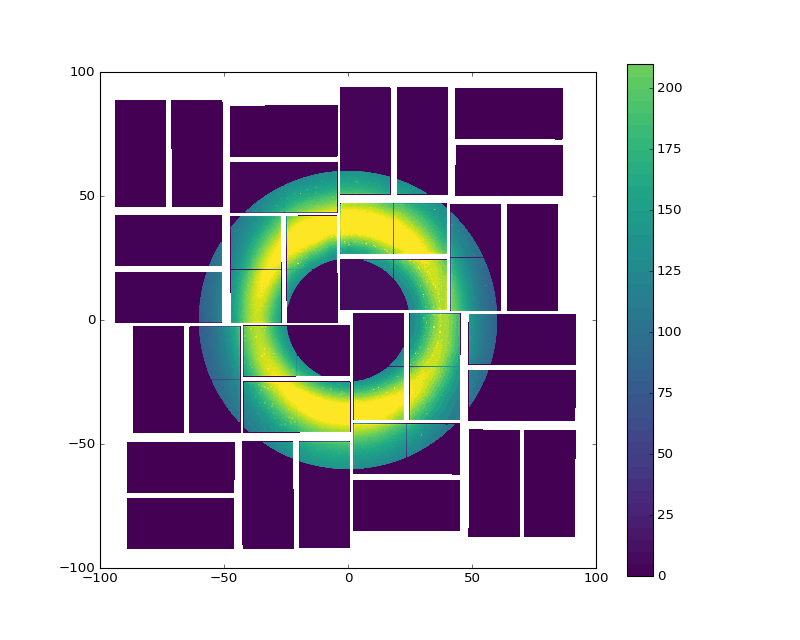

In [252]:
rbinned = np.digitize(R, [0., 25, 60, 1000])
Z2 = Z.ravel().copy()
Z2[rbinned!= 2] = 0.
Z2 = Z2.reshape(Z.shape)
figure()
for i in range(len(X2)):
    tricontourf(X2[i].ravel(), Y2[i].ravel(), Z2[i].ravel(), 50, vmin=vmin, vmax=vmax, cmap='viridis')

ax = gca()
ax.set_aspect('equal')
colorbar()

<IPython.core.display.Javascript object>


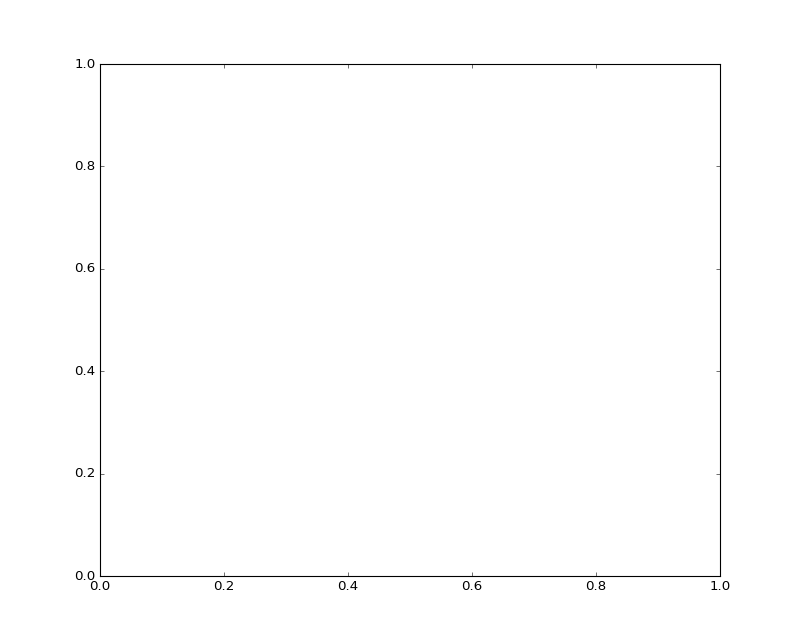

ValueError: x and y must have same first dimension

In [256]:
rbins = np.arange(0, 1000)
c = np.bincount(np.digitize(R, rbins), weights=Z2.reshape(-1))
figure()
plot(rbins, c[:-1])

In [257]:
c.shape

(131,)

In [37]:
Z2 = exposure.equalize_hist(Z)
figure()
Z3 = custom_threshold(Z2, upper=0.5, uvalue=0., lower=0.25, lvalue=0.)
X, Y = d.coords_xy(events[0])
X = X/1000
Y = Y/1000
Z3[..., -50:] = 0. # mask off dirty things

# select points which have values above lower threshold
idx = np.where(Z3 > Z3.min())
# find x, y coordinates of these places
XY = np.stack([X[idx], Y[idx]]).T

# circinfo = LMA(XY, [-0., -40, 40])
#circinfo2 = list(circinfo)
#circinfo2[1] -= 10
#circinfo2[2] += 10

# mask lower corners of X and Y
X2 = X
Y2 = Y
#X2 = X - circinfo2[0]
#Y2 = Y - circinfo2[1]
vmin, vmax = np.percentile(Z[0], [1, 99])
for i in range(len(X2)):
    tricontourf(X2[i].ravel(), Y2[i].ravel(), Z[i].ravel(), 50, vmin=vmin, vmax=vmax, cmap='viridis')
# tricontourf(X2[1].ravel(), Y2[1].ravel(), Z[1].ravel(), 50, vmin=vmin, vmax=vmax, cmap='viridis')
# tricontourf(X2[2].ravel(), Y2[2].ravel(), Z[2].ravel(), 50, vmin=vmin, vmax=vmax, cmap='viridis')

ax = gca()
#ax.add_patch(matplotlib.patches.Circle((0, 0), radius=circinfo2[2], fill=False))

#xlim(-1.5*circinfo2[2], 1.5*circinfo2[2])
#ylim(-1.5*circinfo2[2], 1.5*circinfo2[2])
ax.set_aspect('equal')

colorbar()

(500, 30)

In [57]:
#!/usr/bin/env python 

from __future__ import division
from builtins import zip
from builtins import map
from builtins import range
from past.utils import old_div
import numpy
from numpy import *



x = r_[  9., 35., -13.,  10.,  23.,   0.]
y = r_[ 34., 10.,   6., -14.,  27., -10.]
#x = x / max(x)
#y = y / max(y)

# this is the main function which performs the entire curve fitting sequence using algebraic and geometric fitting
def AraiCurvature(x=x,y=y):
    """
    input: list of x points, list of y points
    output: k, a, b, SSE.  curvature, circle center, and SSE
    Function for calculating the radius of the best fit circle to a set of 
    x-y coordinates.
    Paterson, G. A., (2011), A simple test for the presence of multidomain
    behaviour during paleointensity experiments, J. Geophys. Res., in press,
    doi: 10.1029/2011JB008369

    """
    # makes sure all values are floats, then norms them by largest value
    X = numpy.array(list(map(float, x)))
    X = old_div(X, max(X))
    Y = numpy.array(list(map(float, y)))
    Y = old_div(Y, max(Y))
    XY = numpy.array(list(zip(X, Y)))
                  
    #Provide the intitial estimate
    E1=TaubinSVD(XY);

    #Determine the iterative solution
    E2=LMA(XY, E1);

    estimates=[E2[2], E2[0], E2[1]];
    
    best_a = E2[0]
    best_b = E2[1]
    best_r = E2[2]

    if best_a <= numpy.mean(X) and best_b <= numpy.mean(Y):
        k = old_div(-1.,best_r)
    else:
        k = old_div(1.,best_r)

    SSE = get_SSE(best_a, best_b, best_r, X, Y)
    return k, best_a, best_b, SSE


def TaubinSVD(XY):
    """
    algebraic circle fit
    input: list [[x_1, y_1], [x_2, y_2], ....]
    output: a, b, r.  a and b are the center of the fitting circle, and r is the radius

     Algebraic circle fit by Taubin
      G. Taubin, "Estimation Of Planar Curves, Surfaces And Nonplanar
                  Space Curves Defined By Implicit Equations, With
                  Applications To Edge And Range Image Segmentation",
      IEEE Trans. PAMI, Vol. 13, pages 1115-1138, (1991)
    """
    XY = numpy.array(XY)
    X = XY[:,0] - numpy.mean(XY[:,0]) # norming points by x avg
    Y = XY[:,1] - numpy.mean(XY[:,1]) # norming points by y avg
    centroid = [numpy.mean(XY[:,0]), numpy.mean(XY[:,1])]
    Z = X * X + Y * Y  
    Zmean = numpy.mean(Z)
    Z0 = old_div((Z - Zmean), (2. * numpy.sqrt(Zmean)))
    ZXY = numpy.array([Z0, X, Y]).T
    U, S, V = numpy.linalg.svd(ZXY, full_matrices=False) # 
    V = V.transpose()
    A = V[:,2]
    A[0] = old_div(A[0], (2. * numpy.sqrt(Zmean)))
    A = numpy.concatenate([A, [(-1. * Zmean * A[0])]], axis=0)
    a, b = (-1 * A[1:3]) / A[0] / 2 + centroid 
    r = numpy.sqrt(A[1]*A[1]+A[2]*A[2]-4*A[0]*A[3])/abs(A[0])/2;
    return a,b,r

# VarCircle() is used with the geometric fit function LMA()
def VarCircle(XY, Par):  # must have at least 4 sets of xy points or else division by zero occurs
    """
    computing the sample variance of distances from data points (XY) to the circle Par = [a b R]
    """
    if type(XY) != numpy.ndarray:
        XY = numpy.array(XY)
    n = len(XY)
    if n < 4:
        raise Warning("Circle cannot be calculated with less than 4 data points.  Please include more data")
    Dx = XY[:,0] - Par[0]
    Dy = XY[:,1] - Par[1]
    D = numpy.sqrt(Dx * Dx + Dy * Dy) - Par[2]
    result = old_div(numpy.dot(D, D),(n-3))
    return result


def LMA(XY,ParIni):
    """
    input: list of x and y values [[x_1, y_1], [x_2, y_2], ....], and a tuple containing an initial guess (a, b, r)
           which is acquired by using an algebraic circle fit (TaubinSVD)
    output: a, b, r.  a and b are the center of the fitting circle, and r is the radius
    %     Geometric circle fit (minimizing orthogonal distances)  
    %     based on the Levenberg-Marquardt scheme in the
    %     "algebraic parameters" A,B,C,D  with constraint B*B+C*C-4*A*D=1
    %        N. Chernov and C. Lesort, "Least squares fitting of circles",
    %        J. Math. Imag. Vision, Vol. 23, 239-251 (2005)
    """
    factorUp=10
    factorDown=0.04
    lambda0=0.01
    epsilon=0.000001
    IterMAX = 50
    AdjustMax = 20
    Xshift=0  
    Yshift=0  
    dX=1  
    dY=0;                                                                                    
    n = len(XY);      # number of data points

    anew = ParIni[0] + Xshift
    bnew = ParIni[1] + Yshift
    Anew = old_div(1.,(2.*ParIni[2]))                                                                              
    aabb = anew*anew + bnew*bnew    
    Fnew = (aabb - ParIni[2]*ParIni[2])*Anew 
    Tnew = numpy.arccos(old_div(-anew,numpy.sqrt(aabb))) 
    if bnew > 0:
        Tnew = 2*numpy.pi - Tnew
    VarNew = VarCircle(XY,ParIni) 

    VarLambda = lambda0;  
    finish = 0;  
                                                                                                      
    for it in range(0,IterMAX):
                                                                      
        Aold = Anew  
        Fold = Fnew
        Told = Tnew
        VarOld = VarNew

        H = numpy.sqrt(1+4*Aold*Fold);                                                                 
        aold = -H*numpy.cos(Told)/(Aold+Aold) - Xshift;
        bold = -H*numpy.sin(Told)/(Aold+Aold) - Yshift;
        Rold = old_div(1,abs(Aold+Aold)); 

        DD = 1 + 4*Aold*Fold; 
        D = numpy.sqrt(DD);  
        CT = numpy.cos(Told); 
        ST = numpy.sin(Told);    
        H11=0; 
        H12=0; 
        H13=0; 
        H22=0; 
        H23=0; 
        H33=0; 
        F1=0; 
        F2=0; 
        F3=0;           
                                                            
        for i in range(0,n):
            Xi = XY[i,0] + Xshift;   
            Yi = XY[i,1] + Yshift;       
            Zi = Xi*Xi + Yi*Yi;  
            Ui = Xi*CT + Yi*ST;             
            Vi =-Xi*ST + Yi*CT;

            ADF = Aold*Zi + D*Ui + Fold;    
            SQ = numpy.sqrt(4*Aold*ADF + 1);           
            DEN = SQ + 1;                                          
            Gi = 2*ADF/DEN;   
            FACT = 2/DEN*(1 - Aold*Gi/SQ);      
            DGDAi = FACT*(Zi + 2*Fold*Ui/D) - Gi*Gi/SQ;                
            DGDFi = FACT*(2*Aold*Ui/D + 1);
            DGDTi = FACT*D*Vi;    
                                                          
            H11 = H11 + DGDAi*DGDAi;                 
            H12 = H12 + DGDAi*DGDFi;                           
            H13 = H13 + DGDAi*DGDTi;                                          
            H22 = H22 + DGDFi*DGDFi;
            H23 = H23 + DGDFi*DGDTi;                                     
            H33 = H33 + DGDTi*DGDTi;                        
                                                 
            F1 = F1 + Gi*DGDAi; 
            F2 = F2 + Gi*DGDFi;    
            F3 = F3 + Gi*DGDTi;


        for adjust in range(1,AdjustMax):
                                              
#             Cholesly decomposition                                     
                                                                       
            G11 = numpy.sqrt(H11 + VarLambda);
            G12 = old_div(H12,G11)                                                                              
            G13 = old_div(H13,G11)
            G22 = numpy.sqrt(H22 + VarLambda - G12*G12);                                                              
            G23 = old_div((H23 - G12*G13),G22);                                             
            G33 = numpy.sqrt(H33 + VarLambda - G13*G13 - G23*G23);                
                                                                                   
            D1 = old_div(F1,G11);                                            
            D2 = old_div((F2 - G12*D1),G22);                                                              
            D3 = old_div((F3 - G13*D1 - G23*D2),G33);                

            dT = old_div(D3,G33);  
            dF = old_div((D2 - G23*dT),G22) 
            dA = old_div((D1 - G12*dF - G13*dT),G11) 
                                                                                   
#            updating the parameters
                                                                                            
            Anew = Aold - dA;  
            Fnew = Fold - dF;                             
            Tnew = Told - dT;

            if 1+4*Anew*Fnew < epsilon and VarLambda>1:  
                Xshift = Xshift + dX;                                          
                Yshift = Yshift + dY;                                                                               
                                                                                     
                H = numpy.sqrt(1+4*Aold*Fold);                               
                aTemp = -H*numpy.cos(Told)/(Aold+Aold) + dX;                                     
                bTemp = -H*numpy.sin(Told)/(Aold+Aold) + dY;                                      
                rTemp = old_div(1,abs(Aold+Aold));                                       
                                                                             
                Anew = old_div(1,(rTemp + rTemp));                         
                aabb = aTemp*aTemp + bTemp*bTemp;                          
                Fnew = (aabb - rTemp*rTemp)*Anew;                             
                Tnew = numpy.arccos(old_div(-aTemp,numpy.sqrt(aabb)));                                       
                if bTemp > 0:
                    Tnew = 2*numpy.pi - Tnew;           
                VarNew = VarOld;                                         
                break;                               

            
            if 1+4*Anew*Fnew < epsilon:  
                VarLambda = VarLambda * factorUp;             
                continue;              

            DD = 1 + 4*Anew*Fnew;                  
            D = numpy.sqrt(DD);                                                         
            CT = numpy.cos(Tnew);                                
            ST = numpy.sin(Tnew);    
                    
            GG = 0;                
                            

            for i in range(0, n):
                Xi = XY[i,0] + Xshift;          
                Yi = XY[i,1] + Yshift;    
                Zi = Xi*Xi + Yi*Yi; 
                Ui = Xi*CT + Yi*ST;            
                                                 
                ADF = Anew*Zi + D*Ui + Fnew;                    
                SQ = numpy.sqrt(4*Anew*ADF + 1);               
                DEN = SQ + 1;                   
                Gi = 2*ADF/DEN; 
                GG = GG + Gi*Gi;
                                   
            VarNew = old_div(GG,(n-3));    
         
            H = numpy.sqrt(1+4*Anew*Fnew);               
            anew = -H*numpy.cos(Tnew)/(Anew+Anew) - Xshift;  
            bnew = -H*numpy.sin(Tnew)/(Anew+Anew) - Yshift;  
            Rnew = old_div(1,abs(Anew+Anew)); 

            if VarNew <= VarOld: 
                progress = old_div((abs(anew-aold) + abs(bnew-bold) + abs(Rnew-Rold)),(Rnew+Rold));      
                if progress < epsilon: 
                    Aold = Anew;          
                    Fold = Fnew;      
                    Told = Tnew;           
                    VarOld = VarNew # %#ok<NASGU>  
                    finish = 1;     
                    break;  

                VarLambda = VarLambda * factorDown
                break  
            else:                 #    %   no improvement  
                VarLambda = VarLambda * factorUp;      
                continue;     

        if finish == 1:
            break

    H = numpy.sqrt(1+4*Aold*Fold);                                                                                        
    result_a = -H*numpy.cos(Told)/(Aold+Aold) - Xshift;                                                      
    result_b = -H*numpy.sin(Told)/(Aold+Aold) - Yshift;                                                 
    result_r = old_div(1,abs(Aold+Aold));       

    return result_a, result_b, result_r



def get_SSE(a,b,r,x,y):
    """
    input: a, b, r, x, y.  circle center, radius, xpts, ypts
    output: SSE
    """
    SSE = 0
    X = numpy.array(x)
    Y = numpy.array(y)
    for i in range(len(X)):
        x = X[i]
        y = Y[i]
        v = (numpy.sqrt( (x -a)**2 + (y - b)**2 ) - r )**2
        SSE += v
    return SSE




#if __name__ == "__main__":
#x = numpy.array([  9, 35, -13,  10,  23,   0])
#y = numpy.array([ 34, 10,   6, -14,  27, -10])
#AraiCurvature(x, y)

In [74]:
np.shape(data_orig)

(10, 704, 768)

In [16]:
psana.DetNames(nametype='all')

[('NoDetector.0:Evr.1', 'evr1', ''),
 ('XppEndstation.0:USDUSB.0', 'usbencoder', ''),
 ('XppGon.0:Cspad.0', 'cspad', ''),
 ('NoDetector.0:Evr.0', 'evr0', ''),
 ('XppGon.0:Epix100a.1', 'epix_1', ''),
 ('EBeam', '', ''),
 ('PhaseCavity', '', ''),
 ('FEEGasDetEnergy', '', ''),
 ('XppMon_Pim0', '', ''),
 ('XppMon_Pim1', '', ''),
 ('XppEnds_Ipm0', '', ''),
 ('XPP-SB2-BMMON', '', ''),
 ('XPP-SB3-BMMON', '', ''),
 ('XppEndstation.0:Opal1000.1', 'opal_1', ''),
 ('ControlData', '', ''),
 ('BEAM:LCLS:ELEC:Q', 'eBeam_charge', ''),
 ('BEND:DMP1:400:BDES', 'eBeam_energy', ''),
 ('EVNT:SYS0:1:LCLSBEAMRATE', 'photonBeam_Rate', ''),
 ('FOIL:LI24:804:MOTR.RBV', 'eBeam_slottedFoil_BC2_readback', ''),
 ('FOIL:LI24:804:MOTR.VAL', 'eBeam_slottedFoil_BC2', ''),
 ('GATT:FEE1:310:R_ACT', 'fee_GasAttenuator_calculated_transmission', ''),
 ('HVCH:FEE1:241:VoltageMeasure', 'fee_GasDetector_1_PMT_voltage_241', ''),
 ('HVCH:FEE1:242:VoltageMeasure', 'fee_GasDetector_1_PMT_voltage_242', ''),
 ('HVCH:FEE1:361:Voltag

In [ ]:
 ('XPP:USER:LAS:E_PULSE', 'lxe', ''),
 ('XPP:USER:LXT', 'lxt', ''),
 ('XPP:USER:LXTTC', 'lxt_ttc', ''),
 ('XPP-SB3-BMMON', '', ''),
('XPP:LAS:MMN:05.RBV', 'las_lensv', ''),
 ('XPP:LAS:MMN:06.RBV', 'las_lensh', ''),
 ('XPP:LAS:MMN:08.RBV', 'las_lensf', ''),
 ('XPP:LAS:MMN:11.RBV', 'las_tt_wp', ''),
 ('XPP:LAS:MMN:09.RBV', 'las_opa_wp', ''),
('XPP:USER:CCM:E', 'ccm_E', ''),
('XPP:LAS:MMN:04.RBV', 'las_delayNew', ''),
 
 ('XPP:TIMETOOL:AMPL', '', ''),
 ('XPP:TIMETOOL:AMPLNXT', '', ''),
 ('XPP:TIMETOOL:FLTPOS', '', ''),
 ('XPP:TIMETOOL:FLTPOSFWHM', '', ''),
 ('XPP:TIMETOOL:FLTPOS_PS', '', ''),
 ('XPP:TIMETOOL:REFAMPL', '', ''),

In [17]:
        epics_vars = [
            'lxe',
            'lxt',
            'lxt_ttc',
            'XPP-SB3-BMMON',
            'las_lensv',
            'las_lensh',
            'las_lensf',
            'las_tt_wp',
            'las_opa_wp',
            'ccm_E',
            'las_delayNew',
            'XPP:TIMETOOL:AMPL',
            'XPP:TIMETOOL:AMPLNXT',
            'XPP:TIMETOOL:FLTPOS',
            'XPP:TIMETOOL:FLTPOSFWHM',
            'XPP:TIMETOOL:FLTPOS_PS',
            'XPP:TIMETOOL:REFAMPL',
            ]


In [19]:
len(epics_vars)

17